# DTLZ2 Benchmark
## Imports

In [20]:
from bofire.benchmarks.multi import DTLZ2
from bofire.benchmarks.benchmark import run
from bofire.utils.multiobjective import compute_hypervolume
from bofire.samplers import PolytopeSampler
from bofire.strategies.random import RandomStrategy
from bofire.domain import Domain
from bofire.strategies.botorch.qehvi import BoTorchQehviStrategy
from functools import partial

## Run strategies

In [2]:
num_optimizations = 1
num_iterations = 50
batch_size = 1

### Random Strategy

In [23]:
def sample(domain):
    sampler = PolytopeSampler(domain=domain)
    sampled = sampler.ask(10)
    return sampled

def hypervolume(domain: Domain) -> float:
    assert domain.experiments is not None
    return compute_hypervolume(
        domain, domain.experiments, ref_point={"f_0": 1.1, "f_1": 1.1}
    )

random_results = run(
    DTLZ2(dim=6),
    strategy_factory=RandomStrategy,
    n_iterations=50,
    metric=hypervolume,
    #initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 0.071: 100%|██████████| 50/50 [00:00<00:00, 123.55it/s]


In [21]:
results = run(
    DTLZ2(dim=6),
    strategy_factory=partial(BoTorchQehviStrategy, ref_point={"f_0": 1.1, "f_1": 1.1}),
    n_iterations=50,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 0.393: 100%|██████████| 50/50 [02:47<00:00,  3.36s/it]


In [3]:
random_studies = []
for i in range(num_optimizations):
    study = DTLZ2_(dim=6)
    study.optimize(RandomStrategy(use_sobol=False), batch_size=batch_size, num_iterations=num_iterations)
    random_studies.append(study)

100%|██████████| 50/50 [00:03<00:00, 13.85it/s, fbest=0.0984]


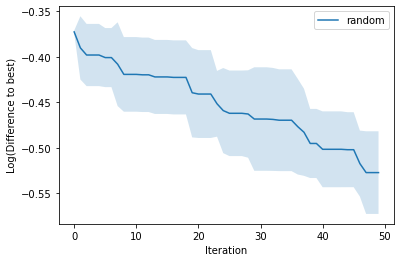

In [5]:
#ax = plot_optimization_history(bo_studies,error_bar=True, log_scale=True, label = "qEI")
ax = plot_optimization_history(random_studies,error_bar=True, log_scale=True, label = "random", best_possible_f=random_studies[0].best_possible_hypervolume,)
ax.legend()
plt.show()

### QPAREGO

In [3]:
bo_studies2 = []

for i in range(num_optimizations):
    study = DTLZ2_(dim=6)
    #study.optimize(BoTorchQnehviStrategy(ref_point=study.ref_point,categorical_encoding="ONE_HOT",categorical_method="EXHAUSTIVE"),num_iterations=50)
    study.optimize(BoTorchQparegoStrategy(categorical_encoding="ONE_HOT",categorical_method="EXHAUSTIVE"),num_iterations=50)
    bo_studies2.append(study)

100%|██████████| 50/50 [17:10<00:00, 20.61s/it, fbest=0.219] 


### QNEHVI

In [4]:
bo_studies = []

for i in range(num_optimizations):
    study = DTLZ2_(dim=6)
    #study.optimize(BoTorchQnehviStrategy(ref_point=study.ref_point,categorical_encoding="ONE_HOT",categorical_method="EXHAUSTIVE"),num_iterations=50)
    study.optimize(BoTorchQehviStrategy(ref_point=study.ref_point,categorical_encoding="ONE_HOT",categorical_method="EXHAUSTIVE"),num_iterations=50)
    bo_studies.append(study)

100%|██████████| 50/50 [07:45<00:00,  9.31s/it, fbest=0.37] 


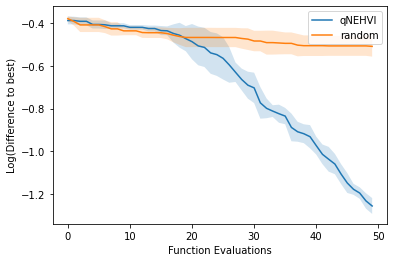

In [13]:
ax = plot_optimization_history(bo_studies,error_bar=True, log_scale=True, label = "qNEHVI", best_possible_f=random_studies[0].best_possible_hypervolume)
ax = plot_optimization_history(random_studies,error_bar=True, log_scale=True, label = "random", best_possible_f=random_studies[0].best_possible_hypervolume,ax=ax)
ax.legend()
plt.show()

In [18]:
benchmark = DTLZ2_(dim=6)
random_strategy = RandomStrategy.from_domain(benchmark.domain)
experiments = benchmark.run_candidate_experiments(random_strategy.ask(candidate_count=1000)[0])

studies = []
for i in range(2):
    pool = PoolStudy(domain=benchmark.domain,num_starting_experiments=10,experiments=experiments,metrics="HYPERVOLUME", ref_point=benchmark.ref_point)
    my_strategy = BoTorchQehviStrategy(ref_point=benchmark.ref_point,categorical_encoding="ONE_HOT",categorical_method="EXHAUSTIVE")
    pool.optimize(my_strategy,num_iterations=50)
    studies.append(pool)

100%|██████████| 50/50 [09:26<00:00, 11.33s/it, dist2best=0.0217]


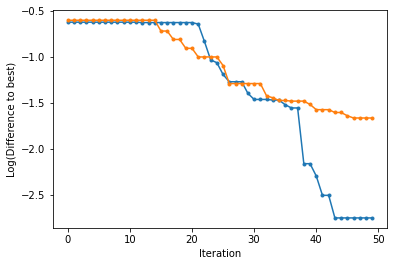

In [19]:
plot_pooloptimization_history(studies, error_bar=False, log_scale=True)
plt.show()

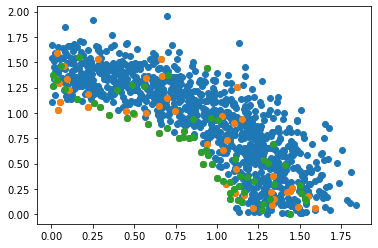

In [25]:
fig, ax = plt.subplots()
ax.scatter(pool.experiments.f_0,pool.experiments.f_1)
ax.scatter(studies[0].picked_experiments.f_0,studies[0].picked_experiments.f_1)
ax.scatter(studies[1].picked_experiments.f_0,studies[1].picked_experiments.f_1)
plt.show()

### Run it in ACB

In [20]:
dtlz = DTLZ2_(dim=6)


strategy = RandomStrategy.from_domain(dtlz.domain)
df_candidates, _ = strategy.ask(candidate_count = 10)
df_experiments = dtlz.run_candidate_experiments(df_candidates)


# recommender = BoTorchQehviStrategy(
#     descriptor_encoding = "DESCRIPTOR",
#     categorical_encoding = "ONE_HOT",
#     categorical_method = "EXHAUSTIVE",
#     num_restarts = 4,
#     num_sobol_samples = 512,
#     num_raw_samples  = 512,
# )

recommender = BoTorchQehviStrategy(
    ref_point=dtlz.ref_point,
    categorical_encoding="ONE_HOT",
    categorical_method="EXHAUSTIVE",
    num_sobol_samples = 512,
)


dataset_id, feature2ids, constraints2ids = datascience.create_dataset(
    name="DTLZ2",
    description="DTLZ benchmark",
    ownerGroupId=36,
    strategy=recommender,
    domain = dtlz.domain
)

datascience.create_experiments(
    experiments=df_experiments,
    dataset_id=dataset_id,
)

print(dataset_id)
print(feature2ids)
print(constraints2ids)




205
{'x_0': 1526, 'x_1': 1527, 'x_2': 1528, 'x_3': 1529, 'x_4': 1530, 'x_5': 1531, 'f_0': 1532, 'f_1': 1533}
{'LINEAR_EQUALITY': 5, 'LINEAR_INEQUALITY': 6, 'CONCURRENCY': 7}


In [21]:
datascience.run(
    #domain=himmel.domain,
    dataset_id=dataset_id,
    #features=feature2ids,
    num_iterations=40,
    candidate_count=1,
    objective_function=dtlz.run_candidate_experiments,
)

100%|██████████| 40/40 [30:48<00:00, 46.20s/it]


In [9]:
datascience.get_candidates(dataset_id,last_state=False)

,x_0,x_1,x_2,x_3,x_4,x_5,f_0_pred,f_1_pred,f_0_sd,f_1_sd,f_0_des,f_1_des,candidate_id,proposal_id,state
0,1.0,0.083868,0.537557,0.143010,0.045417,0.787308,0.479158,1.090533,0.406718,0.418468,-0.479158,-1.090533,197,255,PROCESSED
1,1.0,0.584252,0.458762,0.340627,0.358091,0.833317,0.421758,1.129919,0.385962,0.421293,-0.421758,-1.129919,198,256,PROCESSED


In [10]:
datascience.get_experiments(dataset_id)

,x_0,x_1,x_2,x_3,x_4,x_5,f_0,f_1,valid_f_0,valid_f_1,candidate_id
0,0.006712,0.522914,0.210884,0.672133,0.521018,0.120394,1.258216e+00,0.013267,True,True,NaN
1,0.968763,0.277008,0.600693,0.390996,0.161098,0.785620,6.220066e-02,1.266654,True,True,NaN
2,0.517195,0.887394,0.448405,0.828239,0.409070,0.672368,8.930160e-01,0.942608,True,True,NaN
3,0.491483,0.125373,0.870877,0.109616,0.769104,0.484071,1.076880e+00,1.048445,True,True,NaN
4,0.276604,0.864015,0.633972,0.236673,0.980181,0.225528,1.383946e+00,0.642240,True,True,NaN
5,0.747935,0.117253,0.056405,0.955538,0.338652,0.931402,6.799221e-01,1.626537,True,True,NaN
6,0.762185,0.733421,0.896441,0.267594,0.090646,0.544164,5.237436e-01,1.336207,True,True,NaN
7,0.229152,0.472501,0.286230,0.548976,0.732060,0.361360,1.050026e+00,0.395175,True,True,NaN
8,0.162416,0.973120,0.951318,0.927726,0.218503,0.402748,1.644180e+00,0.428811,True,True,NaN
9,0.813036,0.227204,0.373824,0.146359,0.608201,0.690768,3.657558e-01,1.209403,True,True,NaN


In [11]:
dtlz.domain.get_feature_reps_df()

,Type,Description
x_0,ContinuousInputFeature,"[0.0,1.0]"
x_1,ContinuousInputFeature,"[0.0,1.0]"
x_2,ContinuousInputFeature,"[0.0,1.0]"
x_3,ContinuousInputFeature,"[0.0,1.0]"
x_4,ContinuousInputFeature,"[0.0,1.0]"
x_5,ContinuousInputFeature,"[0.0,1.0]"
f_0,ContinuousOutputFeature,MinIdentityDesirabilityFunction
f_1,ContinuousOutputFeature,MinIdentityDesirabilityFunction


In [30]:
experiments = datascience.get_experiments(dataset_id)
experiments

,x_0,x_1,x_2,x_3,x_4,x_5,f_0,f_1,valid_f_0,valid_f_1,candidate_id
0,0.207131,0.488609,0.283001,0.063018,0.492901,0.555252,1.176152e+00,0.396773,True,True,NaN
1,0.762018,0.881626,0.605604,0.701379,0.845416,0.002709,5.711187e-01,1.455946,True,True,NaN
2,0.510978,0.045615,0.158862,0.323706,0.732893,0.402696,9.849794e-01,1.019551,True,True,NaN
3,0.456458,0.589999,0.983665,0.943149,0.116655,0.912146,1.323057e+00,1.153412,True,True,NaN
4,0.362258,0.163851,0.710493,0.756004,0.156099,0.690518,1.160358e+00,0.742171,True,True,NaN
5,0.666656,0.708334,0.400768,0.383378,0.506681,0.243419,5.663807e-01,0.980963,True,True,NaN
6,0.919755,0.372226,0.832939,0.513532,0.883881,0.351412,1.630272e-01,1.286512,True,True,NaN
7,0.114746,0.765342,0.024432,0.128337,0.265716,0.841360,1.580101e+00,0.287927,True,True,NaN
8,0.034543,0.071431,0.811227,0.446062,0.774000,0.954350,1.562650e+00,0.084873,True,True,NaN
9,0.995159,0.558320,0.112653,0.818806,0.376573,0.479572,9.662027e-03,1.270691,True,True,NaN


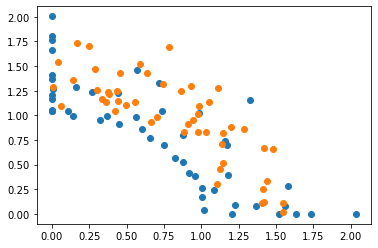

In [33]:
fig, ax = plt.subplots()
#ax.scatter(pool.experiments.f_0,pool.experiments.f_1)
ax.scatter(experiments.f_0,experiments.f_1)

#ax.scatter(bo_studies[0].experiments.f_0,bo_studies[0].experiments.f_1)
ax.scatter(random_studies[0].experiments.f_0,random_studies[0].experiments.f_1)
#ax.scatter(studies[1].picked_experiments.f_0,studies[1].picked_experiments.f_1)
plt.show()

In [29]:
from everest.utils.multiobjective import compute_hypervolume, get_pareto_front


optimal_experiments = get_pareto_front(dtlz.domain,bo_studies[0].experiments)
compute_hypervolume(dtlz.domain, optimal_experiments, dtlz.ref_point)

0.36124193766601